In [40]:
import pandas as pd, numpy as np
import os
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.parser import parse

workPath = "/home/xetra/AlphaGoldmine/Data/"
future = "CL"
y = 2018

# calPath = os.path.join(workPath, "Calendar/Calendar")
contFuture = os.path.join(workPath, future.lower(), f"{future}Cont")
vbPath = os.path.join(workPath, future.lower(), f"{future}ContVB")
# contFutureML = os.path.join(workPath, future.lower(), f"{future}ContML")
# contFutureML1 = os.path.join(workPath, future.lower(), f"{future}ContML1")
# miniSetML = os.path.join(workPath, future.lower(), f"{future}{y}ML")

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# RollGaps and Non-Negative Price Series

In [41]:
def getGaps(series,cols={"contract":"contract","open":"o","close":"c"},backRoll=True):
    rollDates = series[cols["contract"]].drop_duplicates(keep="first").index
    gaps = series[cols["close"]]*0
    iloc = list(series.index)
    iloc = [iloc.index(i)-1 for i in rollDates]
    gaps.loc[rollDates[1:]] = series[cols["open"]].loc[rollDates[1:]] - series[cols["close"]].iloc[iloc[1:]].values
    gaps=gaps.cumsum()
    if backRoll: gaps-=gaps.iloc[-1]
    return gaps

def applyRolls(df,ohlc=["o","h","l","c"],cols={"contract":"contract","open":"o","close":"c"},backRoll=True):
    gaps=getGaps(df,cols,backRoll)
    for c in ohlc:df[c]-=gaps
    return df[ohlc]

In [42]:
df = pd.read_feather(contFuture).set_index("date")

In [43]:
def getNonNegRolledPrice(df,ohlc=["o","h","l","c"],cols={"contract":"contract","open":"o","close":"c"}):
    gaps=getGaps(df)
    gaps.plot(label="gaps")
    rolled = df[ohlc].copy(deep=True)
    for c in ohlc:rolled[c]-=gaps
    plt.plot(rolled["c"]-df["c"], label="rolled")
    plt.legend()
    rolled["returns"] = rolled[cols["close"]].diff()/df[cols["close"]].shift(1)
    return (1+rolled["returns"]).cumprod().rename("rPrices")

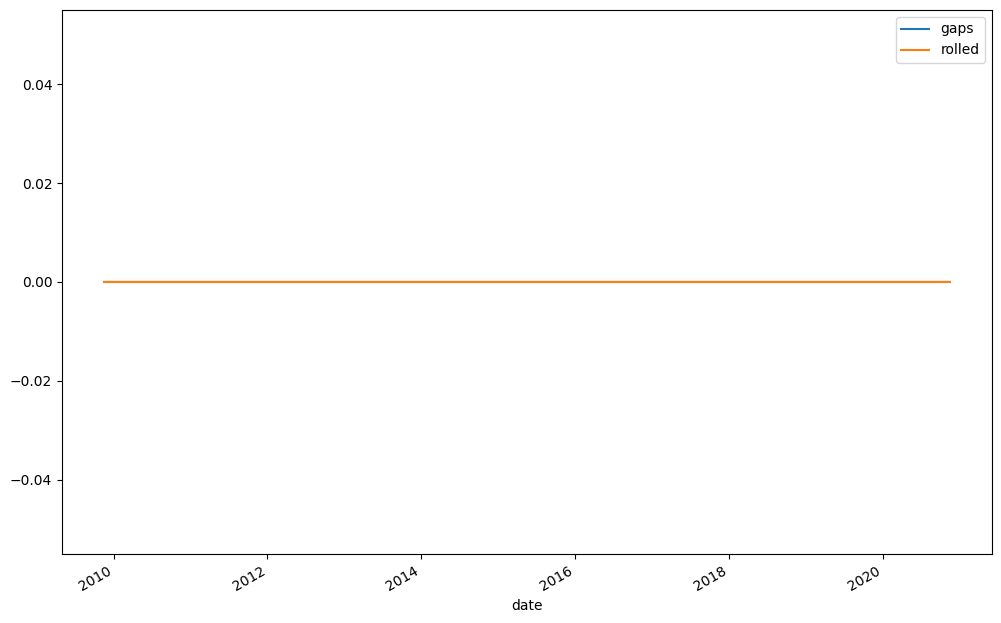

In [44]:
df["rPrices"] = getNonNegRolledPrice(df)

In [45]:
ohlc = ["o","h","l","c"]
df[ohlc] = applyRolls(df,ohlc=ohlc)
df

,o,h,l,c,vol,nrT,bidVol,askVol,contract,rPrices
date,,,,,,,,,,
2009-11-17 00:00:00,131.97,131.97,131.97,131.97,1,0,0,0,CLF10,NaN
2009-11-17 00:01:00,132.01,132.04,132.01,132.04,18,0,0,0,CLF10,1.000530
2009-11-17 00:02:00,132.05,132.11,132.05,132.11,45,0,0,0,CLF10,1.001061
2009-11-17 00:03:00,132.11,132.13,132.11,132.13,20,0,0,0,CLF10,1.001212
2009-11-17 00:04:00,132.10,132.10,132.10,132.10,2,0,0,0,CLF10,1.000985
...,...,...,...,...,...,...,...,...,...,...
2020-11-13 16:54:00,40.14,40.15,40.13,40.15,17,16,12,5,CLZ20,0.304236
2020-11-13 16:55:00,40.14,40.15,40.13,40.14,96,88,49,47,CLZ20,0.304160
2020-11-13 16:56:00,40.13,40.14,40.13,40.13,24,18,16,8,CLZ20,0.304084


# PCA Weights
#### What are they good for?

# Sampling Features
### Why?
- Several ML algos do not scale well with sample size(SVM)
- ML algos achive highest accuracy when they attemt to learn from relevant examples.

### The Rational bihind it
Suppose you want to predict 5% rally or 5% sell-off. At any **random** time, the accuracy of such prediction will be low. However, if we ask classifier to predict the sign of the next 5% **after certain catalystic conditions**, we are more likely to find **informative features** that will help us achieve a more accurate prediction.

# Volume Bars

In [46]:
from tqdm import tqdm
def getGroupbyIndex(s, m=1000):
    ts, tmp, idx = 0, 0, []
    for v in tqdm(s):
        ts+=v
        idx.append(tmp)
        if ts >= m: 
            ts = 0
            tmp+=1
    return idx

def getVolumeBars(df,vol,suffix,thr=1000,how={"o":"first","h":"max","l":"min","c":"last","vol":"sum","nrT":"sum","bidVol":"sum","askVol":"sum","date":"last"}):
    temp = getGroupbyIndex(df[vol], m=thr)
    print(f"Getting {len(set(temp))} VolumeBars from {len(df)} entries")
    df["temp"] = temp
    vb = df.groupby("temp").agg(how).add_suffix(suffix)
    return vb.reset_index(drop=True).rename(columns={"dateVb":"date"}).set_index("date")

In [47]:
df = df[~(df.index == df.vol.idxmax())] #Dropping a huge outlier probably cuz of data issues

In [48]:
vb = getVolumeBars(df.reset_index(), "vol", "Vb",thr=1000)

100%|██████████| 3821311/3821311 [00:01<00:00, 3324352.38it/s]


Getting 647914 VolumeBars from 3821311 entries


# Volume Imbalance Bars
### Skiping this part cuz i need tick data for this

In [49]:
### using it instead of the ugly function in the link. replace returns()
def bt(close):
    return np.sign(close.pct_change().replace(0,np.nan).fillna(method="ffill").dropna()).rename("bt")
linkToCode="https://github.com/boyboi86/AFML/blob/master/AFML%202.1.1.ipynb"

# Event-Based Sampling
The idea here is to charactarize an event as significant and let the ML algorithm learn whether there is an accurate prediction function under those circumstances. Later there will be more on this topic.

One of such examples is **VPIN** == **probability of informed Trading**. If it is high enough a bar will be sampled.

In [65]:
def VPIN(b,s,v,n=1000):
    return abs(b-s).rolling(window=n).sum() / v.rolling(window=n).sum()

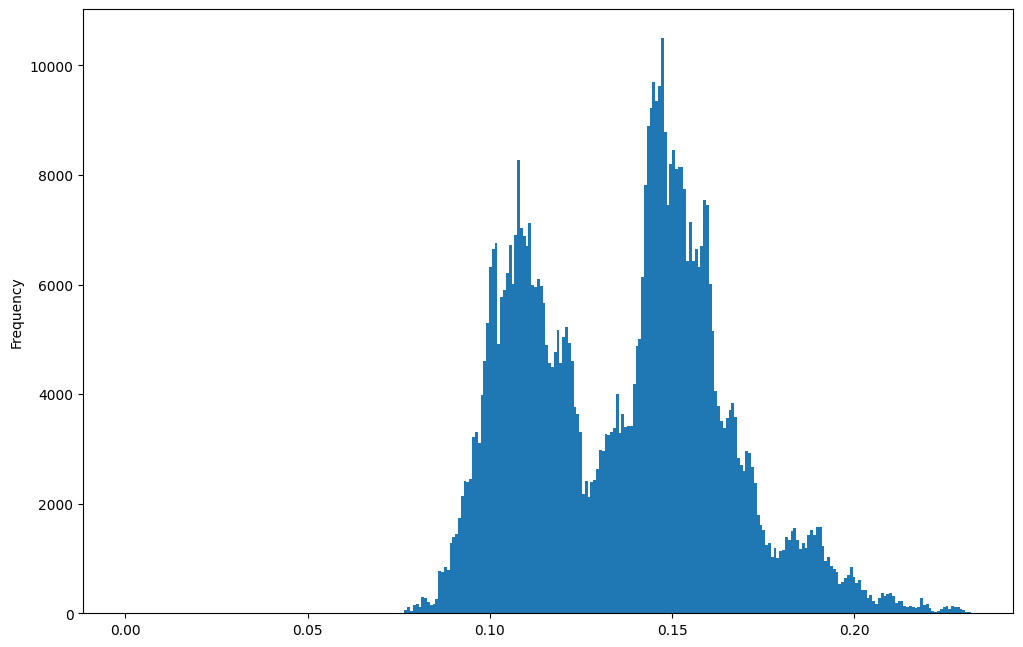

In [66]:
VPIN(vb["askVolVb"],vb["bidVolVb"],vb["volVb"],1000).replace(0,np.nan).dropna().plot(kind="hist",bins=300)

In [67]:
vb["VPIN"] = VPIN(vb["askVolVb"],vb["bidVolVb"],vb["volVb"],1000)

In [70]:
vb= vb.dropna()

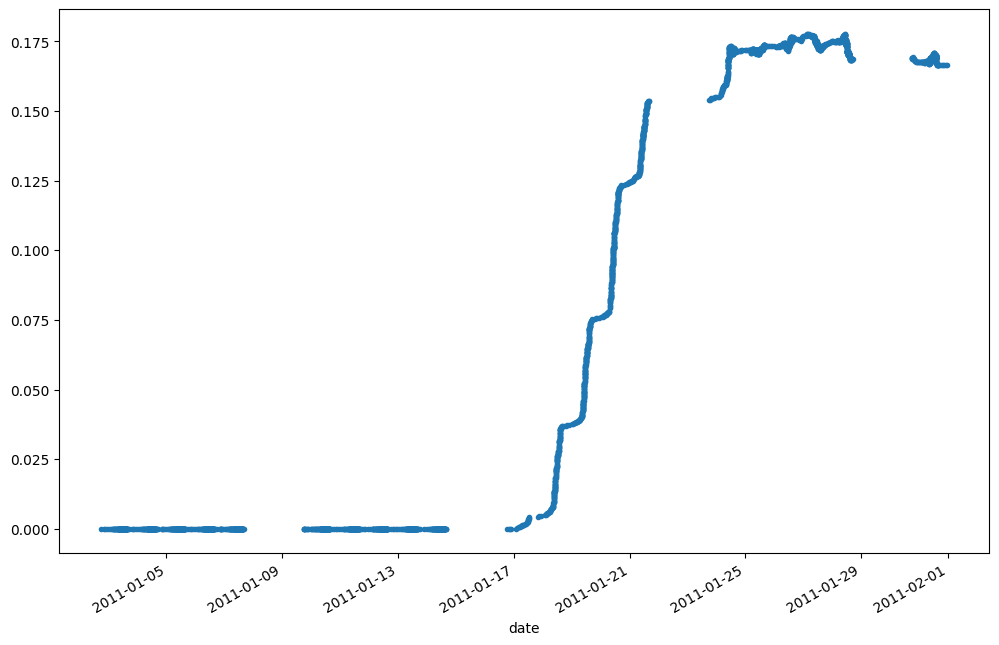

In [77]:
vb.loc[(vb.index.year==2011)&(vb.index.month==1),"VPIN"].plot(style=".")

# The CUSUM Filter 
### helps to provide significance.
It is a quality-control method, designed to detect shifts of measured qty from a target value.

In [53]:
def getTEvents(gRaw,h):
    tEvents,sPos,sNeg = [],0,0
    diff=gRaw.diff()
    for i in diff.index[1:]:
        sPos,sNeg=max(0,sPos+diff.loc[i]),min(0,sNeg+diff.loc[i])
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

Filter former calculated **VPIN** for significant shift = h. Where h = VPIN.std() / f. It is just a fine tune to create more signals, and add some noise as well, to some degree. Without it signals are fare to scarse. I chose f=12 as a sort of an average per year approximation.

In [35]:
f = 12

In [73]:
vpinCUSUM

DatetimeIndex(['2011-01-17 11:11:00', '2011-01-17 22:59:00',
               '2011-01-18 07:13:00', '2011-01-18 09:00:00',
               '2011-01-18 09:22:00', '2011-01-18 09:55:00',
               '2011-01-18 10:23:00', '2011-01-18 10:50:00',
               '2011-01-18 11:29:00', '2011-01-18 11:45:00',
               ...
               '2020-11-04 14:04:00', '2020-11-05 10:57:00',
               '2020-11-05 21:55:00', '2020-11-06 12:04:00',
               '2020-11-09 04:09:00', '2020-11-09 14:10:00',
               '2020-11-10 09:38:00', '2020-11-11 06:13:00',
               '2020-11-12 04:37:00', '2020-11-13 06:46:00'],
              dtype='datetime64[ns]', length=6061, freq=None)

In [72]:
vpinCUSUM = getTEvents(vb["VPIN"],round(vb['VPIN'].replace(0,np.nan).dropna().std(),4)/f)

In [37]:
vc = vpinCUSUM.groupby(vpinCUSUM.week)
avgSignalPerWeek = sum([len(v)/10 for v in vc.values()]) / 52
print(f"SignalPerWeek: {avgSignalPerWeek}")

SignalPerWeek: 11.655769230769227


<ipython-input-37-c219b526d4c9>:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  vc = vpinCUSUM.groupby(vpinCUSUM.week)


<ipython-input-38-9a47db645ca7>:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  d = vb[(vb.index.week == 15) & (vb.index.year == 2020)]


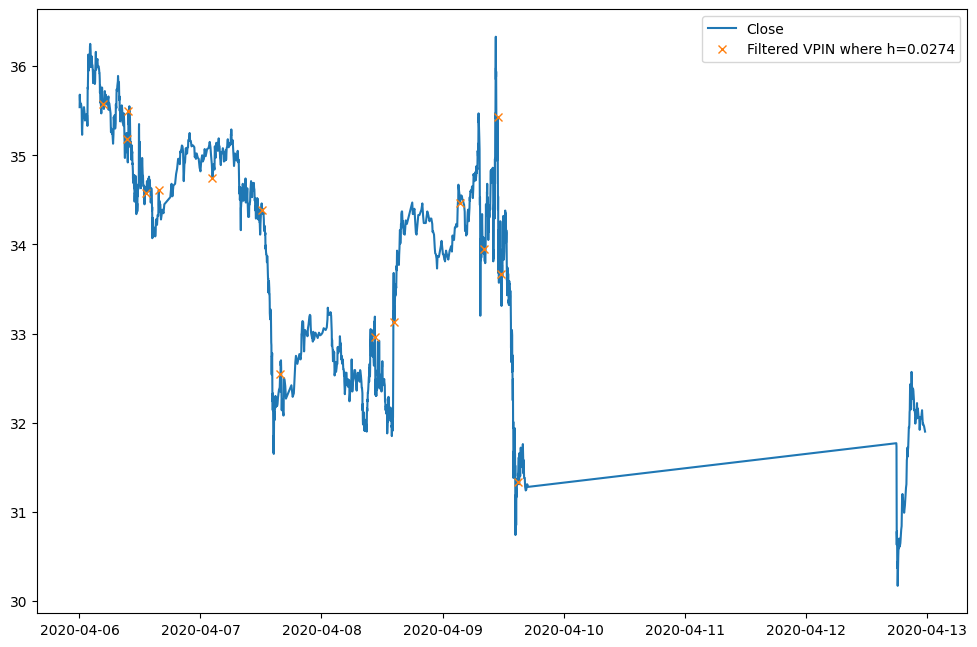

In [38]:
d = vb[(vb.index.week == 15) & (vb.index.year == 2020)]
plt.plot(d["cVb"].dropna(), label="Close", zorder=1)
plt.plot(d.loc[d.index.intersection(vpinCUSUM), "cVb"], "x", label=f"Filtered VPIN where h={round(vb['VPIN'].replace(0,np.nan).dropna().std(),4)}")
plt.legend()

**Note** 

Due to minute data, VPIN is heavyly approximated, because, although data is volume based sampled, it is not sampled fine enough. As a result it chops only inactivity in *asia* and *eu* session but does not add bars in volatile times or during active trading. Which is a bummer. Tick data is strogly needed.

In [39]:
df#.reset_index().to_feather(contFuture)
vb.reset_index().to_feather(vbPath)